In [1]:
# Usual Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

import os

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, optimizers, losses, callbacks
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input, BatchNormalization
from tensorflow.keras.layers import\
    Conv2D, ZeroPadding2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD

# from tensorflow.keras import layers
# from tensorflow.keras import models
from IPython import display

from sklearn.model_selection import train_test_split

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
if not (os.path.exists('genres_original')):
    !unzip "/content/drive/MyDrive/MUS106/Data.zip" -d "/content"

In [4]:
def getData(batch_size, path='data/'):
    total = keras.utils.image_dataset_from_directory(
        directory=path+'/',
        labels='inferred',
        label_mode='categorical',
        batch_size=batch_size,
        image_size=(432, 288)
    )
    total = total.map(lambda X, y: (X / 255, y))
    total_size = total.cardinality().numpy()

    print(total_size)

    total = total.shuffle(batch_size)
    train = total.take(total_size * 0.8)
    test = total.skip(total_size * 0.8)
    return train, test

def decode_audio(audio_binary):
    # Decode WAV-encoded audio files to `float32` tensors, normalized
    # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    # Since all the data is single channel (mono), drop the `channels`
    # axis from the array.
    return tf.squeeze(audio, axis=-1)

def get_label(file_path):
    parts = tf.strings.split(
        input=file_path,
        sep=os.path.sep)
    # Note: You'll use indexing here instead of tuple unpacking to enable this
    # to work in a TensorFlow graph.
    return parts[-2]

def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label


def get_spectrogram(waveform):
    # Zero-padding for an audio waveform with less than 16,000 samples.
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
        [16000] - tf.shape(waveform),
        dtype=tf.float32)
    # Cast the waveform tensors' dtype to float32.
    waveform = tf.cast(waveform, dtype=tf.float32)
    # Concatenate the waveform with `zero_padding`, which ensures all audio
    # clips are of the same length.
    equal_length = tf.concat([waveform, zero_padding], 0)
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
        equal_length, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
      assert len(spectrogram.shape) == 3
      spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    label_id = tf.math.argmax(label == genres)
    return spectrogram, label_id

def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(
        map_func=get_waveform_and_label,
        num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(
        map_func=get_spectrogram_and_label_id,
        num_parallel_calls=AUTOTUNE)
    return output_ds

In [5]:
data_dir = './images_original'
# genres = list(os.listdir(general_path))
train_ds, test_ds = getData(64, data_dir)

print(train_ds.cardinality().numpy())
print(test_ds.cardinality().numpy())

Found 999 files belonging to 10 classes.
16
12
4


In [6]:
genres = list(os.listdir(data_dir))
genres

['metal',
 'rock',
 'hiphop',
 'country',
 'classical',
 'reggae',
 'blues',
 'disco',
 'jazz',
 'pop']

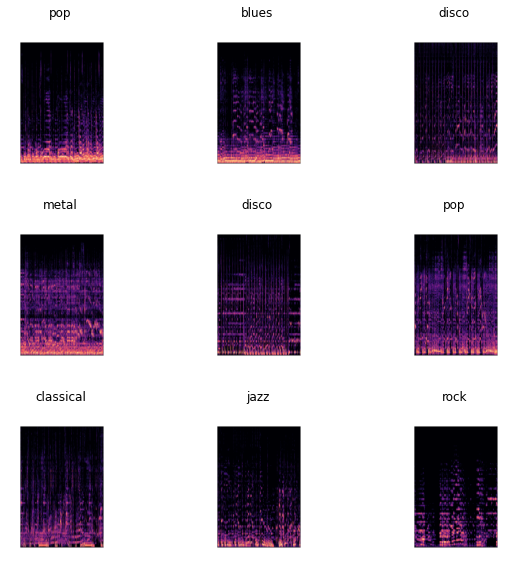

In [7]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, data in enumerate(train_ds.take(n)):
    label = genres[np.argmax(data[1][0])]
    img = data[0][0]
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

plt.show()

In [8]:
input_shape = (432, 288, 3)
print('Input shape:', input_shape)
num_labels = len(genres)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_ds.map(map_func=lambda spec, label: spec))

model = Sequential([
    Input(shape=input_shape),
    # Downsample the input.
    # layers.Resizing(32, 32),
    # Normalize.
    # norm_layer,

    Conv2D(8, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2, 2)),

    Conv2D(16, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(32, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(axis=-1),
    Activation('relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(axis=-1),
    Activation('relu'),
    MaxPooling2D((2, 2)),



    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(num_labels, activation='softmax')
])

model.summary()


Input shape: (432, 288, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 432, 288, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 432, 288, 8)      32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 432, 288, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 216, 144, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 216, 144, 16)      1168      
                                                                 
 batch_normalization_1 (Batc 

In [9]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
EPOCHS = 100
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    verbose=1
    # callbacks=callbacks.EarlyStopping(verbose=1, patience=2),
)


Epoch 1/100
12/12 [==============================] - 15s 491ms/step - loss: 11.9932 - accuracy: 0.1319 - val_loss: 2.3627 - val_accuracy: 0.0820
Epoch 2/100
12/12 [==============================] - 7s 388ms/step - loss: 2.7694 - accuracy: 0.1144 - val_loss: 2.2949 - val_accuracy: 0.1055
Epoch 3/100
12/12 [==============================] - 8s 390ms/step - loss: 2.2653 - accuracy: 0.1615 - val_loss: 2.3364 - val_accuracy: 0.0909
Epoch 4/100
12/12 [==============================] - 8s 389ms/step - loss: 2.2560 - accuracy: 0.1523 - val_loss: 2.3471 - val_accuracy: 0.1039
Epoch 5/100
12/12 [==============================] - 8s 391ms/step - loss: 2.2424 - accuracy: 0.1400 - val_loss: 2.4416 - val_accuracy: 0.1039
Epoch 6/100
12/12 [==============================] - 8s 397ms/step - loss: 2.2445 - accuracy: 0.1471 - val_loss: 2.4975 - val_accuracy: 0.1055
Epoch 7/100
12/12 [==============================] - 8s 395ms/step - loss: 2.2367 - accuracy: 0.1359 - val_loss: 2.5740 - val_accuracy: 0.09

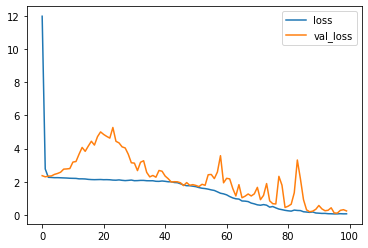

In [11]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()


In [12]:
test_acc = model.evaluate(test_ds)[1]
print(f'Test set accuracy: {test_acc}')

4/4 [==============================] - 3s 37ms/step - loss: 0.1803 - accuracy: 0.9567
Test set accuracy: 0.9567099809646606


In [14]:
model.save('drive/MyDrive/MUS106/GenreSpectrogramClassifier')

INFO:tensorflow:Assets written to: drive/MyDrive/MUS106/GenreSpectrogramClassifier/assets
